### Problem Statement
[insert]


### Import Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# https://data.ny.gov/Transportation/Turnstile-Usage-Data-2016/ekwu-khcy
# https://data.ny.gov/api/views/ekwu-khcy/rows.csv?accessType=DOWNLOAD
# http://web.mta.info/developers/data/nyct/turnstile/turnstile_170603.txt
# parse_dates = pd.datetools.to_datetime
# data = pd.read_html('http://web.mta.info/developers/data/nyct/turnstile/turnstile_170603.txt',parse_dates=True, dtype={'C/A': str,'Unit':str,'SCP':str,'Station':str,'Line Name':str, 'Division':str,'Date': object, 'Time':object,'Description':str,'Entries':int,'Exits':int})
data = pd.read_csv('turnstile_170603.txt')

data = pd.DataFrame(data) # change to pandas dataframe
# parse spaces from columns; to use better approach when 
data=data.rename(columns = {'EXITS                                                               ':'EXITS'})
# Do we need to convert Date column to datetime?
# data['Date'] = data['Date'].to_datetime()
# data['Date'] = data['Date'].dt.date
print(data.columns)
data.head()

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,00:00:00,REGULAR,6195217,2098317
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,04:00:00,REGULAR,6195240,2098318
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,08:00:00,REGULAR,6195256,2098347
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,12:00:00,REGULAR,6195346,2098432
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,16:00:00,REGULAR,6195518,2098491


In [3]:
# data['Date'] = data['Date'].astype('datetime64') # convert data column to date type
# print(type(data['Date']))
# remove first few columns, deemed irrelevant
# data = data.iloc[:,:]
# data.head()

### Process Data

In [4]:
data = data.groupby(["STATION", "DATE",'TIME'],as_index=False).max() # sort by station, date
data.head()

,STATION,DATE,TIME,C/A,UNIT,SCP,LINENAME,DIVISION,DESC,ENTRIES,EXITS
0,1 AV,05/27/2017,00:00:00,H008,R248,01-00-04,L,BMT,REGULAR,953673205,997710509
1,1 AV,05/27/2017,04:00:00,H008,R248,01-00-04,L,BMT,REGULAR,953673206,997710509
2,1 AV,05/27/2017,08:00:00,H008,R248,01-00-04,L,BMT,REGULAR,953673208,997710512
3,1 AV,05/27/2017,12:00:00,H008,R248,01-00-04,L,BMT,REGULAR,953673209,997710514
4,1 AV,05/27/2017,16:00:00,H008,R248,01-00-04,L,BMT,REGULAR,953673210,997710514


In [5]:
data = data.groupby(['STATION','DATE']).agg(lambda x: max(x) - min(x))
data.head()

ENTRIES  EXITS
STATION DATE                      
1 AV    05/27/2017        6      6
        05/28/2017        2      4
        05/29/2017        0      1
        05/30/2017     2232   1587
        05/31/2017     2130   1622

In [6]:
# Groupby Station, Day
# data = data.groupby(["STATION", "DATE"],as_index=False).max() # sort by station, date
# data = pd.DataFrame(data)
# data.head()

In [8]:
# Data presented as cumulative; add columns to track the increment
# Add Traffic_Tot column as sum of Entry and Exit to represent activity
# data['Entry_Inc'] = abs(data.ENTRIES.diff())
# # data['Entry_Inc2'] = data['Entry_Inc']

# data['Exits_Inc'] = abs(data.EXITS.diff())
data['Traffic_Tot'] = np.add(data.ENTRIES, data.EXITS)
data.head()

ENTRIES  EXITS  Traffic_Tot
STATION DATE                                   
1 AV    05/27/2017        6      6           12
        05/28/2017        2      4            6
        05/29/2017        0      1            1
        05/30/2017     2232   1587         3819
        05/31/2017     2130   1622         3752

In [15]:
# filter outliers above specified quantile
quant_filt = 0.99
q = data["ENTRIES"].quantile(quant_filt)
data = data[data["ENTRIES"] < q]

r = data["EXITS"].quantile(quant_filt)
data = data[data["EXITS"] < r]

s = data["Traffic_Tot"].quantile(quant_filt)
data = data[data["Traffic_Tot"] < s]
# data = data.dropna() # apparently no issues with NaN cells; running as best practice
data2 = data
data2.head()

ENTRIES  EXITS  Traffic_Tot
STATION DATE                                   
1 AV    05/27/2017        6      6           12
        05/28/2017        2      4            6
        05/29/2017        0      1            1
        05/30/2017     2232   1587         3819
        05/31/2017     2130   1622         3752

### Sort Data
Data is sorted by Station.

In [ ]:
# data2['Dates'] = data2.index # Make Station_ID a non-index column
# # data_stn['Idx'] = np.arange(data_stn.shape[0]) # add enumerated column
# # data_stn = data_stn.set_index('Idx') # assign enumerated column as index column
# data_stn.head()

In [ ]:
# data_stndatetime = data.groupby([ "Station", "Date",'Time']).sum() # sort by station, date and time
# data_stndatetime.head()

In [16]:
data_stn = data2.groupby(["STATION"]).sum() # sort by station
# data_stn = pd.DataFrame(data_stn) # convert to panda dataframe
data_stn['Station_ID'] = data_stn.index # Make Station_ID a non-index column
data_stn = data_stn.sort_values(['Traffic_Tot'], ascending=[False]) # Sort stations by traffic
data_stn['Idx'] = np.arange(data_stn.shape[0]) # add enumerated column
data_stn = data_stn.set_index('Idx') # assign enumerated column as index column
data_stn.head()

,ENTRIES,EXITS,Traffic_Tot,Station_ID
Idx,,,,
0,5120417656,7383531343,12503948999,CANAL ST
1,3492993369,8206036002,11699029371,CLINTON-WASH AV
2,3052335174,5308151308,8360486482,KINGS HWY
3,5419743057,2126715439,7546458496,14 ST
4,3770992566,2367466984,6138459550,GRD CNTRL-42 ST


## Prep Data for Charting

In [17]:
# demographic data: NYC census
# map of startups in NYC
# calendar of tech events
# unicorn 

# import seaborn as sns
sns.set_style("whitegrid")


In [18]:
data_stn_chart = data_stn.iloc[:20,:] # limit to 20 most active stations

data_stn_chart.head()


,ENTRIES,EXITS,Traffic_Tot,Station_ID
Idx,,,,
0,5120417656,7383531343,12503948999,CANAL ST
1,3492993369,8206036002,11699029371,CLINTON-WASH AV
2,3052335174,5308151308,8360486482,KINGS HWY
3,5419743057,2126715439,7546458496,14 ST
4,3770992566,2367466984,6138459550,GRD CNTRL-42 ST


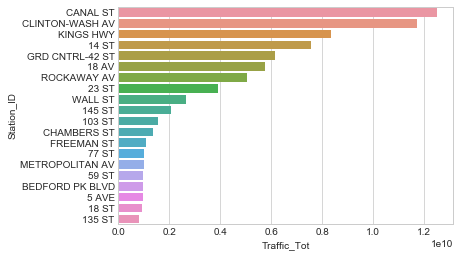

In [19]:
# verify results: check http://web.mta.info/nyct/facts/ffsubway.htm
ax = sns.barplot(x="Traffic_Tot", y='Station_ID', data=data_stn_chart)
# gut feeling is that 23rd St is not a top station.  If more time, would
# further analyze 23rd Street for outliers.


In [ ]:
# PROBLEM STATEMENT
# Optimize utilization of street teams by using data science by utilizing MTA 
# and [Demographic] data

# PRESENTATION
# Executive Summary / Scenario
# MTA findings
# Demographic findings
# Combined MTA/Demo Analysis
# Conclusion
# Q&A

# TODO:
# Clean up JN
# day/hour analyses
# combine demographic data
# Map which includes demographic data (ie income) and station activity (by size of dot)
# Analyze top stations by time period (season, month, week, day, hour)
# add lat/long
# vet data better / graph 

# Tomorrow morning
# Finished pres, practice

### Top Station Activity: Penn Station 34th Street

In [ ]:
data_Penn = data_stn[data_stn['Station_ID'] == '34 ST-PENN STA']
# data_Penn.head()
np.max(data_Penn['Traffic_Tot'])


In [ ]:
y = pd.Series(data_Penn['Traffic_Tot'])
x = pd.Series(data_Penn['DATE'])

plt.plot(x,y)
# axes = plt.gca()
# axes.set_ylim([1000,2000])
plt.show()

### Top Station Activity: 23rd St

In [ ]:
data_23ST = data[data['Station_ID'] == '23 ST']
# data_23ST.head()
np.max(data_23ST['Traffic_Tot'])


In [ ]:
y = pd.Series(data_23ST['Traffic_Tot'])
x = pd.Series(data_23ST['Date'])

plt.plot(x,y)
# axes = plt.gca()
# axes.set_ylim([1000,2000])
plt.show()

### Top Station Activity: 72nd St

In [ ]:
data_72ST = data[data['Station_ID'] == '72 ST']
y = pd.Series(data_72ST['Traffic_Tot'])
x = pd.Series(data_72ST['Date'])

plt.plot(x,y)
# axes = plt.gca()
# axes.set_ylim([1000,2000])
plt.show()

In [ ]:
data = pd.DataFrame(data)
data['Date'] = pd.to_datetime(data['Date'])
type(data['Date'])